# 4 - Further work with confocal image datasets

<a name="outline"></a>

## Outline of this notebook

* <a href="#4.0">4.0 - Loading the data</a>


* <a href="#4.1">4.1 - Indexing Numpy arrays and plotting them</a>

    * <a href="#exercise-projection"> Exercise - Calculate the maximum projection </a>

    * <a href="#exercise-cropping">Exercise - Cropping the dataset and plotting it</a>

    * <a href="#exercise-documentation">Exercise - Using the documentation to figure out how to modify plotting behavior</a>


* <a href="#4.2">4.2 - Using statistics from file to analyze image</a>

    * <a href="#exercise-overlaying">Exercise - Overlaying a scatterplot on the image</a>

    * <a href="#exercise-extract">Exercise - Extract a fixed volume relative to puncta coordinates</a>

    * <a href="#exercise-repeat">Exercise - Repeat for the receptor signal</a>


* <a href="#4.3">4.3 - Quantifying the receptor signal</a>

    * <a href="#exercise-calculate">Exercise - Calculate mean receptor signal near each puncta</a>

    * <a href="#exercise-histogram">Exercise - Plot histogram of receptor signal and count number of functional synapses</a>


* <a href="#4.4">4.4 - Bonus - Creating a composite image</a>

## Introduction

Over the previous two days you've learned how to work extensively with DataFrames, a type of object provided by the Pandas library. Today, you will work with Numpy arrays. Much like DataFrames and lists, arrays are use to store sets of data.  Also, like dataframes and lists, arrays allow you to pull out subsets of data using slicing. Unlike Pandas DataFrames which are designed to work with tabular data, Numpy arrays are designed to work with multidimensional data. This makes them especially well suited for confocal datasets, which often contain three-dimensional image data. We'll talk more about this in a few minutes.

## The data format

Imaris is a third-party program that facilitates analysis of data acquired from a confocal and saves it in an open-sorce format based on HDF5. HDF5 stands for hierarchial data format version 5. A number of programming languages have packages for reading this file format. There are two main packages for Python, `h5py` and `pytables`. We will use `pytables` today.

## The data

Up to 25 auditory nerve fibers synapse onto individual inner hair cells in
normal-hearing individuals. However, these synapses can be permanently lost due
to aging, exposure to noise or ototoxic drugs.  In experiments that study
hearing loss, we need a way of quantifying the number of synapses per inner
hair cell.

One approach is to dissect the cochlea out of the experimental animals and use
whole-mount immunohistochemistry to label the tissue with antibodies for
pre-synaptic ribbons (CtBP2), post-synaptic receptors (GluR2) and cytoskeleton
(Myosin VIIa). In a second step, each antibody is tagged with a fluorescent dye
that can be illuminated using a laser (much like how a black light can cause
certain materials to glow).

The distribution of these fluorescent dyes (which map to the underlying
distribution of the proteins of interest) can be captured by taking a series of
two-dimensional images at various depths in the tissue.  These images are then
"stacked" to create a three-dimensional image known as a Z-stack (since the
third dimension is commonly referred to as the Z-axis).

For this exercise, the dataset has been trimmed down to a small subset showing
only two inner hair cells (the full dataset is 0.5 GB in size) with CtBP2 (fig.
1a) and GluR2 (fig. 1b).

**For simplicity, we will refer to the CtBP2 label as "ribbon" and the GluR2 label as "receptor".**

<table>
	<body>
		<tr>
			<td>1A. CtBP2 (pre-synaptic ribbon)</td>
			<td>1B. GluR2 (post-synaptic glutamate receptor)</td>
		</tr>
		<tr>
			<td><img src="data/CtBP2.png" /></td>
			<td><img src="data/GluR2.png" /></td>
		</tr>
	</body>
</table>

During confocal acquisition the signal intensity of each label is acquired as a separate **channel**. For each label, we have a separate set of three-dimensional image data representing the signal intensity for that label.

##  The problem

This dataset was analyzed using Imaris to identify all ribbon puncta (white dots
in fig. 2a). If you look closely at the composite (fig. 2b), you'll see that
not all puncta have a glutamate receptor patch next to them (fig. 2b). 

<table>
	<body>
		<tr>
			<td>A. CtBP2 puncta</td>
			<td>B. CtBP2 puncta overlaid on GluR2</td>
		</tr>
		<tr>
			<td><img src="data/CtBP2+points.png" /></td>
			<td><img src="data/CtBP2+GluR2+points.png" /></td>
		</tr>
	</body>
</table>

A functional inner hair cell synapse requires both a pre-synaptic ribbon and a
post-synaptic glutamate receptor. The next step in our analysis is to determine
whether each ribbon puncta is near a receptor.

One approach is to extract a fixed volume around each ribbon puncta (e.g., a 1um
cube) and quantify the amount of receptor label in that volume. Let's get started!

<a name="4.0"></a>
## 4.0 - Loading the data
<a href="#outline">Jump to outline</a>

First, let's import a few modules we'll need. Remember that a Python module is basically a Python file (or collection of files) that contain useful functions that you can use in your code. 

Most of them are common third-party modules; however, I have written a helper module (`imaris`) to extract some of the statistics (calculated by Imaris). You loaded these statistics from a comma-separated-values file on day 2; however, we are now going to load it directly from the HDF5 file itself.

In [1]:
# Popular third-party libraries
import matplotlib.pyplot as pl
import tables as tb
import numpy as np
import pandas as pd

# Custom module written for this exercise
import imaris

# This is a special "magic" command that can be used in Jupyter Notebooks.
# It ensures that Matplotlib shows the plot below each cell (you won't see
# a plot otherwise).
%matplotlib inline

# Set the default precision for printing data in Numpy arrays.
np.set_printoptions(precision=4)

Now, let's open the file using the `pytables` library. Even though the library
is called `pytables`, it installs itself in Python as `tables` and we imported
it as `tb`.

Here, `tb` is a module and `open_file` is a function defined in the module. The
`open_file` function takes the path to the file and returns a PyTables `File`
object.

You've already worked extensively with objects before. A `DataFrame` is an
object. Even a simple integer is an object! Objects can be thought of as a
collection of data (i.e., attributes on the object) and functions (i.e.,
methods on the object) that operate on this data.

Here, `fh` is a `File` object that knows where the data is stored on disk, but
it hasn't actually loaded the data itself. That's a good thing. HDF5 files can
be several gigabytes in size (most computers only have 8 gigabytes of memory).
However, it has methods that help you load the data you need.

In [2]:
fh = tb.open_file('data/confocal dataset.ims')

Now what? If you've never worked with a particular type of object before, you
can explore it a number of ways. We've already discussed two ways you can
explore them. What are they?

Another way is to just type `print(fh)`. What actually gets printed depends on
how the developers of the library implement it for their particular object.
Sometimes you don't get anything useful. Fortunately, the `PyTables` developers
decided to produce useful output when you call the `print` function on a `File`
object.

Go ahead, try it.

In [3]:
print(fh)

data/confocal dataset.ims (File) ''
Last modif.: 'Wed Dec 13 10:50:49 2017'
Object Tree: 
/ (RootGroup) ''
/DataSet (Group) ''
/DataSetInfo (Group) ''
/DataSetTimes (Group) ''
/DataSetTimes/Time (Table(1,)) ''
/DataSetTimes/TimeBegin (Table(1,)) ''
/Scene (Group) ''
/Scene/Data (VLArray(1,)) ''
/Scene8 (Group) ''
/Scene8/Data (VLArray(1,)) ''
/Thumbnail (Group) ''
/Thumbnail/Data (Array(194, 776)) ''
/Scene8/Content (Group) ''
/Scene8/Content/Points0 (Group) ''
/Scene8/Content/Points0/Category (Table(2,)) ''
/Scene8/Content/Points0/Factor (Table(6,)) ''
/Scene8/Content/Points0/FactorList (Table(6,)) ''
/Scene8/Content/Points0/LabelGroupNames (Table(0,)) ''
/Scene8/Content/Points0/LabelSetLabelIDs (Table(0,)) ''
/Scene8/Content/Points0/LabelSetObjectIDs (Table(0,)) ''
/Scene8/Content/Points0/LabelSets (Table(0,)) ''
/Scene8/Content/Points0/LabelValues (Table(0,)) ''
/Scene8/Content/Points0/MainTrackSegmentTable (Table(1,)) ''
/Scene8/Content/Points0/Spot (Table(47,)) ''
/Scene8/Content/

This is a lot of information. As you can see, it nicely illustrates the
structure of a HDF5 file. Recall how I mentioned HDF5 was short for hierarchial
data format? You can see that the data in the file is nicely organized into
what looks like a file-path like structure (e.g., `/Scene8/Content/Points0`).
Much like your computer filesystem, the data is organized into "folders" (known
as "groups" in HDF5 parlance) and "files" (known as "nodes" in HDF5 parlance).
It's almost like a filesystem within a file.

We're interested in finding the actual three-dimensional image data. Let's look
through the information shown above. Does anything jump out as a clue as to where the data might be stored in the file?

In confocal imaging, each label is acquired using a separate channel. At the
bottom of the list we see several rows that mention `Channel 0`, `Channel 1`
and `Channel 2`. This is most likely the data we need.

However, the channels appear several times (under `ResolutionLevel 0` and
`ResolutionLevel 1`). Which one do we want? Our intuition as a programmer tells
us that Imaris likely generates the dataset at multiple resolutions and uses
the appropriate resolution based on your zoom level. For quantitative analysis,
we probably want the highest resolution level. 

Take another look at the list. You'll notice that at the end of each line
there's an indicator in parenthesis (`Group`, `Array`, `CArray`).  different
types of nodes in the HDF5 file. 

Now, let's look at the `Channel 0/Data` line for each resolution level. There's
some information about the size of the array. This tells us that
`ResolutionLevel 0` contains the highest resolution data and `ResolutionLevel 1` 
contains the lowest resolution data. Otherwise, they should be identical.

<a name="4.1"></a>
## 4.1 - Indexing Numpy arrays and plotting them

<a href="#outline">Jump to outline</a>

Let's take a look at `Channel 0` so we can understand how to work with
the data. Based on the acquisition settings, channel 0 is the ribbon label and channel 1 is the receptor label. Let's start with the ribbon label.

The file object has a method, `get_node` that returns a node object. This node object provides a method, `read`, that loads the data from disk and returns it as a Numpy array object.

The array object has a `shape` attribute that tells you the size of the array.

In [4]:
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data')
data_ribbon = node.read()
print(data_ribbon.shape)

(144, 256, 256)


Note that there are three numbers. Pandas DataFrames only have two (the number
of rows and columns). That's because DataFrames are two-dimensional. In
contrast, we're working with three-dimensional image data. 

You've worked a little with Numpy arrays in the past two days. You can
visualize a DataFrame as a spreadsheet table. Here's a way to visualize a 3D
array.

<img src="data/array_colour_slices.png" />

Since we're working with image data, each element in the array represents a
voxel (i.e., a 3D pixel). The first dimension is the Z-axis, second dimension
the Y-axis and third (last) dimension the X-axis. The ordering of the
dimensions is how Imaris saves the data (for example, another program may
choose to save the Z-axis as the last dimension).

Much like lists and Pandas DataFrames, you can extract a subset of the data.
For example, to pull out the pixel located at XYZ coordinates (60, 20, 50), you
can use index notation. Remember how you do it with a list?

In [5]:
x_list = ['a', 'b', 'c', 'd']
print(x_list[2])

c


Here's how you do it with Numpy arrays. If the desired XYZ coordinates are (60, 20, 50), why does 50 appear first and 60 appear last in the notation below?

In [6]:
data_ribbon[50, 20, 60]

19

### Question

If you want to extract a *range* of values, you can use the slice syntax. How do you extract the first two elements from a list? Do it for `x_list`.

In [7]:
x_list[:2]

['a', 'b']

Let's pull out three elements from each dimension (this gives us a total of 3 x 3 x 3 = 27 values). As shown in the output below the cell, it looks like a set of 3 x 3 arrays that have been stacked 3-high.

In [8]:
data_ribbon[50:53, 20:23, 60:63]

array([[[19, 17, 15],
        [18, 16, 12],
        [18, 16, 11]],

       [[17, 13, 13],
        [18, 13, 10],
        [22, 16,  9]],

       [[13, 10, 12],
        [17, 12,  9],
        [22, 15,  7]]], dtype=uint8)

There are ways to visualize 3D data in Python. However, these approaches are
not readily available out of the box for Jupyter notebooks. Let's focus on simple 2D plotting
instead. A common way of presenting confocal image stacks is to take the
maximum projection along an an axis (i.e., dimension). Let's take the maximum
projection along the first axis (i.e., Z-axis).

On day 2, we talked about how you can calculate statistics along an axis of a Numpy array. This was a very brief introduction to arrays, so let's refresh our memory.

In [9]:
data_2D = np.random.rand(3, 2)
print('Full dataset')
print(data_2D)

Full dataset
[[ 0.1122  0.4037]
 [ 0.4829  0.7241]
 [ 0.5064  0.3924]]


By convention, a two-dimensional array has two axes: the first running vertically downwards across rows (axis 0) and the second running horizontally across columns (axis 1).


### Question

We can pass an axis argument to the Numpy statistics functions (e.g., `mean`, `std`, `mean`) indicating which axis to operate across. If we take the mean of axis 0 (e.g., `np.mean(data_2D, axis=0)`) what is the shape of the result? What about when taking the mean of axis 1?

In [10]:
print('\nMean across axis 0')
print(np.mean(data_2D, axis=0))

print('\nMean across axis 1')
print(np.mean(data_2D, axis=1))


Mean across axis 0
[ 0.3671  0.5067]

Mean across axis 1
[ 0.2579  0.6035  0.4494]


### Question

In addition to using the `mean` function available through the Numpy module (called `np` in this notebook), there is also a `mean` method available through the array object that performs the same operation. Go ahead, try it!

In [11]:
print(data_2D.mean(axis=0))

[ 0.3671  0.5067]


Let's take a look at a very simple 3D array with shape 4 x 3 x 2. When printing a 3D array, Numpy prints out each 2D section separately.

In [12]:
data_3D = np.random.rand(4, 3, 2)

print('Full dataset')
print(data_3D)

Full dataset
[[[ 0.3769  0.1369]
  [ 0.9304  0.269 ]
  [ 0.2979  0.0711]]

 [[ 0.9268  0.6613]
  [ 0.902   0.4188]
  [ 0.2417  0.3218]]

 [[ 0.1922  0.9978]
  [ 0.6469  0.7706]
  [ 0.2508  0.1931]]

 [[ 0.119   0.2157]
  [ 0.9624  0.8752]
  [ 0.0266  0.6414]]]


### Question

What will the shape of the resulting array be if you take the mean of the first axis? Second axis? Third axis?

In [13]:
print('\nMean across axis 0')
print(np.mean(data_3D, axis=0))

print('\nMean across axis 1')
print(np.mean(data_3D, axis=1))

print('\nMean across axis 2')
print(np.mean(data_3D, axis=2))


Mean across axis 0
[[ 0.4037  0.5029]
 [ 0.8605  0.5834]
 [ 0.2042  0.3068]]

Mean across axis 1
[[ 0.5351  0.159 ]
 [ 0.6902  0.4673]
 [ 0.3633  0.6538]
 [ 0.3693  0.5774]]

Mean across axis 2
[[ 0.2569  0.5997  0.1845]
 [ 0.7941  0.6604  0.2817]
 [ 0.595   0.7087  0.222 ]
 [ 0.1673  0.9188  0.334 ]]


<a name="exercise-projection"></a>
### Exercise - calculate the maximum projection
<a href="#outline">Jump to outline</a>

Now, calculate the maximum projection, along the Z-axis, of the confocal image. The maximum projection is the max value along that axis. You can either use the function, `np.max`, or the object method `data_ribbon.max`.

Save it to a variable called `projection`.

In [14]:
projection = data_ribbon.max(axis=0)

Note the shape of the projection. The Z-axis has been dropped, leaving us with a two-dimensional array that we can plot as an image.

In [15]:
print('Shape of full dataset', data_ribbon.shape)
print('Shape of projection', projection.shape)

Shape of full dataset (144, 256, 256)
Shape of projection (256, 256)


Now, let's plot this 2D projection. The `origin='lower left'` argument to `pl.imshow` indicates that the data at `projection[0, 0]` should appear at the lower left corner of the axes instead of the default location (the upper left).

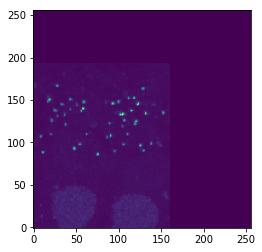

In [16]:
pl.imshow(projection, origin='lower')

<a name="exercise-cropping"></a>
### Exercise - Cropping the dataset and plotting it
<a href="#outline">Jump to outline</a>

It looks like the image has been "padded" with empty data by Imaris, making it a bit ugly to look at. Let's crop out that extra data. To do this, we need to find out what the actual image extents are in pixels. There is a way to do this by looking at the HDF5 file, but this is outside the scope of the exercise. For now, we provide the numbers for you.

Using these numbers, use Numpy indexing to crop out the empty regions and replot the data.

In [17]:
x_pixels = 161
y_pixels = 194
z_pixels = 135

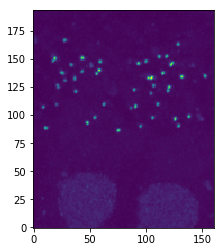

In [18]:
cropped_ribbon = data_ribbon[:z_pixels, :y_pixels, :x_pixels]
projection = cropped_ribbon.max(axis=0)
pl.imshow(projection, origin='lower')

<a name="exercise-documentation"></a>
### Exercise - Using the documentation to figure out how to modify plotting behavior
<a href="#outline">Jump to outline</a>

The units on the X and Y-axes are in pixels. Let's convert them to actual image dimensions (in microns). First, you need to know the actual dimensions (this can be done by looking at the HDF5 file, but we provide the numbers for you). These are the the dimensions of the cropped dataset.

In [19]:
x_um = 22.7418
y_um = 27.442
z_um = 21.526

Now, remember how to get help on a function? Take a look at the documentation for `pl.imshow`. Any clues as to what arguments can be used to get `imshow` to properly map each pixel to it's spatial location in microns? As a bonus, be sure to label the X and Y axes too! You can use the `xlabel` and `ylabel` functions available through the matplotlib.pyplot module (`pl` in this notebook).

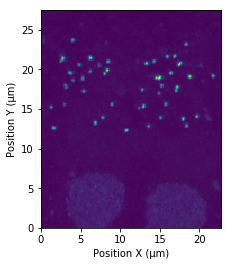

In [20]:
extents = (0, x_um, 0, y_um)
pl.imshow(projection, origin='lower left', extent=extents)
pl.xlabel('Position X (μm)')
pl.ylabel('Position Y (μm)')

<a name="4.2"></a>
## 4.2 - Using statistics from file to analylze image
<a href="#outline">Jump to outline</a>

Now, we need to load the data about the ribbon puncta that were identified using Imaris. Specifically, we need to know the XYZ location of each puncta. A function from the `imaris` module called `load_node_stats` can be used to load this from the Imaris file. The function takes three arguments (the PyTables `File` object, the name of the label and the type of statistics to extract). 

In [21]:
stats_ribbon = imaris.load_node_stats(fh, 'CtBP2', 'point')

<a name="exercise-overlaying"></a>
###  Exercise - overlaying a scatterplot on the image
<a href="#outline">Jump to outline</a>

Our goal is to take the plot we created using `imshow` (with the axes showing the correct spatial location in microns) and overlay a scatterplot showing the location of each ribbon puncta identified by Imaris.

You've already learned how to inspect the contents of a dataframe. Take a look at the dataframe. What type of information does it have? What are the units (e.g., pixels or microns)?

Once you have figured out how to obtain the X and Y coordinates for each puncta, you can plot them using `pl.plot(x_coordinates, y_coordinates, 'r+')` (the `'r+'` specifies a red cross marker). Do the coordinates align with the puncta observed in the image?

In [22]:
stats_ribbon.describe()

name,X,Y,Z
count,47.000000,47.000000,47.000000
mean,10.788394,17.904929,10.624672
std,5.906965,3.049134,3.756406
min,1.294627,12.270201,1.341601
25%,5.309280,15.444492,7.766121
50%,12.321580,18.584343,11.422837
75%,15.770262,20.518848,13.547657
max,21.621861,23.639858,16.378813


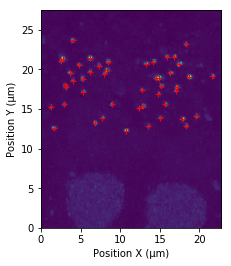

In [23]:
extents = (0, x_um, 0, y_um)
pl.imshow(projection, origin='lower', extent=extents)
x_coordinates = stats_ribbon['X']
y_coordinates = stats_ribbon['Y']

pl.plot(x_coordinates, y_coordinates, 'r+')
pl.xlabel('Position X (μm)')
pl.ylabel('Position Y (μm)')

We want to use this data to extract a 1μm x 1μm x 1μm cube centered around each puncta. To do this we need to convert from microns to pixels. Since we know the dimensions in pixels and microns, we can calculate the size of each pixel.

In [24]:
x_size = x_um/x_pixels
y_size = y_um/y_pixels
z_size = z_um/z_pixels

print('Pixel size (x-axis) {:.2f}'.format(x_size))
print('Pixel size (y-axis) {:.2f}'.format(y_size))
print('Pixel size (z-axis) {:.2f}'.format(z_size))

Pixel size (x-axis) 0.14
Pixel size (y-axis) 0.14
Pixel size (z-axis) 0.16


Each pixel along the X and Y axes are 0.14 microns and the Z axis is 0.16 microns. If we want to convert from microns to pixels, we can divide by the pixel size. This means that a 1μm x 1μm x 1μm cube is approximately 7 x 7 x 6 pixels in size (rounded to the nearest pixel). For simplicity, let's assume that the cube should be 7 x 7 x 7 pixels in size.


<a name="exercise-extract"></a>
### Exercise - extract a fixed volume relative to puncta coordinates 
<a href="#outline">Jump to outline</a>

Now that you know how to convert from microns to pixels, let's pull out the first puncta in the dataframe and plot the maximum projection of the 1μm³ region centered around the puncta.

If you don't remember how to extract the first row of the dataframe, take a look at day 2.

First, one small caveat. When indexing Numpy arrays (and also Python lists), you must use integers. Since divison returns floating point values, you need to cast the result to an integer.

In [25]:
result = 32/4
type(result)

float

In [26]:
int_result = int(round(result))
type(int_result)

int

Now, enter your solution below:
* Convert coordinates stored in first row of dataframe to pixels. Don't forget to cast to an integer!
* Extract cube from `data_ribbon`. Be sure to verify its size is 7 x 7 x 7.
* Compute maximum projection along z-axis and plot it.
* Ensure axes are labeled appropriately and reflect data coordinates, not pixel coordinates.

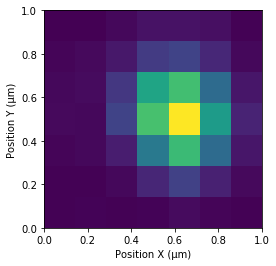

In [27]:
point = stats_ribbon.loc[0]

x_px = int(round(point['X']/x_size))
y_px = int(round(point['Y']/y_size))
z_px = int(round(point['Z']/z_size))

subset_ribbon = data_ribbon[z_px-4:z_px+3, y_px-4:y_px+3, x_px-4:x_px+3]
projection_ribbon = subset_ribbon.max(axis=0)
pl.imshow(projection_ribbon, origin='lower', extent=(0, 1, 0, 1))
pl.xlabel('Position X (μm)')
pl.ylabel('Position Y (μm)')

<a name="exercise-repeat"></a>
### Exercise - repeat for the receptor signal
<a href="#outline">Jump to outline</a>

Looks like we've adequately identified the cube we need. Now, let's load and crop the receptor data so we can plot the amount of receptor signal within this region as well.

In [28]:
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 1/Data')
data_receptor = node.read()
data_receptor = data_receptor[:z_pixels, :y_pixels, :x_pixels]

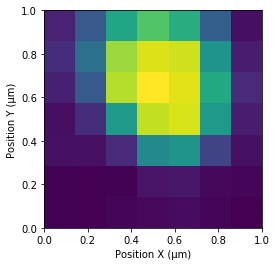

In [29]:
subset_receptor = data_receptor[z_px-4:z_px+3, y_px-4:y_px+3, x_px-4:x_px+3]
projection_receptor = subset_receptor.max(axis=0)
pl.imshow(projection_receptor, origin='lower', extent=(0, 1, 0, 1))
pl.xlabel('Position X (μm)')
pl.ylabel('Position Y (μm)')

<a name="4.3">
## 4.3 - Quantifying the receptor signal
<a href="#outline">Jump to outline</a>

### Question
Looks like there's some receptor signal next to the ribbon signal. Great! Now how do we quantify this? Maybe we can just take the average intensity within this subset? How do we do this?

In [30]:
mean_receptor_signal = subset_receptor.mean()

<a name="exercise-calculate"></a>
### Exercise - Calculate mean receptor signal near each puncta
<a href="#outline">Jump to outline</a>

The next step is to loop through each row (i.e., puncta) in the dataframe and extract the mean receptor signal. This can then be saved back as a new column in the dataframe. We can loop through the rows using the `iterrows` method. On each cycle of the for loop, the `iterrows` method returns two values. The first value is the index of the row and the second value is the data in the row itself (stored in a dictionary-like format).

In [31]:
signal = []
for _, puncta in stats_ribbon.iterrows():
    x_px = int(round(puncta['X']/x_size))
    y_px = int(round(puncta['Y']/y_size))
    z_px = int(round(puncta['Z']/z_size))
    subset_receptor = data_receptor[z_px-4:z_px+3, y_px-4:y_px+3, x_px-4:x_px+3]
    mean_receptor_signal = subset_receptor.mean()
    signal.append(mean_receptor_signal)
    
# Here, we can save the receptor signal back to the statistics dataframe as a new column
stats_ribbon['receptor'] = signal

<a name="exercise-histogram"></a>
### Exercise - plot histogram of receptor signal and count number of functional synapses
<a href="#outline">Jump to outline</a>

Now, let's plot a histogram of the receptor signal near each ribbon puncta. Look at the histogram. Are there any obvious outliers? Is there an obvious cutoff threshold? Based on this, how many functional synapses are there? 

If you're not sure how to plot a histogram. Take a look at the documentation for the `matplotlib.pyplot` module (referred to as `pl` in this notebook). Any particular functions jump out at you?

46


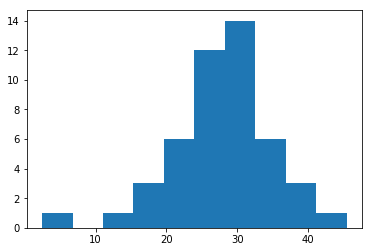

In [32]:
pl.hist(stats_ribbon['receptor'])
mask = stats_ribbon['receptor'] > 10
print(len(stats_ribbon.loc[mask]))

<a name="4.4"></a>
## 4.4 - Bonus - Creating a composite image
<a href="#outline">Jump to outline</a>

In the above images, `imshow` is using a color map in which purple reflects the regions with no signal and yellow reflects regions with the most signal. But, what if we'd like to merge the three channels into a single image where red is mapped to the ribbon and green to the receptor. How can we do this? Let's take another look at the documentation for `imshow`.

It looks `imshow` can take a 3D array where the last dimension maps to the three colors (i.e., `x[..., 0]` is red, `x[..., 1]` is green and `x[..., 2]` is blue). The documentation also warns that the values in the array must be in the range 0 ... 1 for this to work. Let's check that. 

In [33]:
data_ribbon = data_ribbon[:z_pixels, :y_pixels, :z_pixels]
data_receptor = data_receptor[:z_pixels, :y_pixels, :z_pixels]

In [34]:
data_ribbon.max()

253

Uh oh. We need to fix that. The simplest way to coerce data to the range 0 ... 1 is to divide by the maximum value. Let's do this and check that we did OK.

In [35]:
norm_data_ribbon = data_ribbon/np.max(data_ribbon)
norm_data_receptor = data_receptor/np.max(data_receptor)

In [36]:
norm_data_ribbon.max()

1.0

Great. Now we need to make the 2D image for each color and then merge them into a 3D array. A list of 2D images can be stacked into a 3D array using Numpy's `dstack` function. We need to make a blank image for the blue color. The quickest way to do this is to use the `zeros_like` function from Numpy which will create an array of the same shape, but filled with zeros.

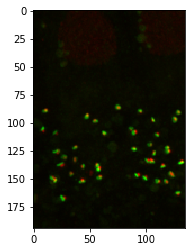

In [37]:
projection_ribbon = norm_data_ribbon.max(axis=0)
projection_receptor = norm_data_receptor.max(axis=0)
projection_blank = np.zeros_like(projection_ribbon)

data = [projection_ribbon, projection_receptor, projection_blank]
projection = np.dstack(data)

pl.imshow(projection)